# Lahars: rivers of concrete

"Lahar" is an Indonesian term that describes a hot of cold mixture of water and rock fragments that flows down the slopes of a volcano and typically enters a river valley [1]. One of the major volcanic hazards, they typically occur around stratovolcanoes- such as the Cascade Range in the Western United States. Lahar events can happen with or without a volcanic eruption- smaller events are often termed "debris flows."

A quick search on YouTube reveals many lahar videos, like this one: https://www.youtube.com/watch?v=TpwiFtVRBTs

Lahars can best be equated to concrete, while it moves- it is a wet, slurry mixture, when it rests, it solidifies into a rocky deposit. Mitigating volcanic risks is a high priority goal for geolgists around the world; if we are able to better predict the behavior of future eruptions, we can warn at risk populations living in hazard zones as well as think about 
engineering structures to protect those populations [2]. 

For this particular lahar model, we will use what we learned in modules 2 and 3 about convection problems. 

When we begin to think about modeling the height of lahars in a numerical space, we first will make some assumptions about the characteristics of our lahar. The first is that our lahar will be of constant width. This assumption limits the applications of this model to lahars that do not experience bulking and debulking. We also are able to reduce the probelm to one dimension with this assumption- simplifying our calculations considerably.The second assumption we will make is that the rheological behavior of our lahar is similar to water. Since we are modeling the lahar while in motion, this is not too bad of an assumption to make. 

To begin our modeling process, we will import our favorite libraries

In [2]:
import numpy 
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
%matplotlib inline

## Derivation of lahar governing equation

The majority of this derivation comes from the textbook, Mathematical Modeling of Earth's Dynamical Systems by Lee Kump and Rudy Slingerland [3]. 

We will start by balancing the lahar mass with conservation. We set up a control volume where the volumetric flow rate is the volumetric flux, q, multiplied by the width. The mass rate out of the section is obtained from a Taylor series. And assuming width and bulk density do not vary in space or time, we get...

$$\frac{\partial h}{\partial t} + \frac{\partial q}{\partial x} = 0$$

This equation looks familiar to us, as it takes the form of our "traffic" model used in Module 2 and 3. We now need to find a way to relate q to h, x, and t. A force balance on a segment of the lahar should do the trick. Starting with the downslope gravity force... A is our cross-sectional area of the flow and we know that as long as the bed slope is small, sin(alpha) equals the bed slope, S. The force opposing gravity is the shear stress multiplied by the area over which it acts, where P is the wetted perimeter...

$$ F_g = \sigma A dx g sin \alpha$$
$$ F_s = \tau_0 P dx $$

If we equate the two in our force balance, we reach an expression for shear stress- where A/P is R- the hydraulic radius. As long as the flow width is 20 times the flow depth, the hydraulic radis is not different from the flow depth, h ; We aso know that a turbulent flow of water exerts a shear stress on its boundaries. This is proportional to the square of the depth averaged velocity multiplied by the drag coefficient... 

$$ \tau_0 = \sigma g R S = C_f \sigma v^2 $$

When we equate these, we can find an expression for velocity of the flow; we will call the first term "Beta"

$$\nu = \sqrt{\frac{g S}{C_f}}\sqrt{h} $$

The expression of velocity is a generalization of the Chezy equation, predicting the cross-sectional average velocity of steady, uniform flows. Substituting our equation for velocity into our definition of q, we find the following expression: 

$$ q = \beta h^k $$

And now we have enough information to return to our governing equations and begin discretizing!

## Discretization of lahar governing equations

For this problem, we will be using the MacCormack scheme. We first learned about this scheme in Module 3, Lesson 2. As a reminder, it is a two step method utilizing a predictor step and a corrector step. It achieves second-order accuracy in both space and time [4]. Our discretized equation looks as follows:

$$ h_i^* = h_i^n - \frac{\Delta t}{\Delta x}(q_{i+1}^n - q_i^n) $$ 
$$ h_i^{n+1} = \frac{1}{2} (h_i^n + h_i^* - \frac{\Delta t}{\Delta x}(q_i^* - q_{i-1}^*)$$

In [3]:
def computeQ(beta, h, k):
    """Parameters:
    beta: coeeficient relating gravity, slope, and drag coefficient
    h: height of lahar
    k: coefficient, given in text
    """  
    return beta*h**k

In [4]:
def lahar_maccormack(h, nt, dt, dx, beta, k):
    
    """Computes the height of the lahar with the MacCormack scheme 
    
    Parameters:
    h: height of the lahar
    nt: number of time steps
    dt: time-step size
    dx: mesh spacing
    alpha: """
    
    #initialize results 
    h_n = numpy.zeros((nt,len(h)))
    h_star = numpy.empty_like(h)
    
    #copy initial array into new array
    h_n[:,:] = h.copy()
    h_star = h.copy()
    
    #compute h_n at time step t+1 and then set h = h_n
    
    for t in range(1,nt):
        q = computeQ(beta, h, k)
        h_star[:-1] = h[:-1] - dt/dx * (q[1:] - q[:-1])
        q_star = computeQ(beta, h_star, k)
        h_n[t,1:] = 0.5 * (h[1:] + h_star[1:] - dt/dx * (q_star[1:] - q_star[:-1]))
        h = h_n[t].copy()
    
    vel = beta * (h**(0.5))

    return h_n, vel

## Defining our lahar field 

In [22]:
#Lahar and river valley characteristics 

g = 9.8     #gravity, m/s^2
S = 0.1     #bed slope, can find this by looking at topographical maps
C_f = 10.0      #drag coefficient of river beds
h_initial = 2.0     #initial height of bed, m
h_max = 30.0 #initial height of source of lahar, m
k = 1.5      #Vignaux and Weir 1990 observed k values for lahars to range from 1.24 to 1.47

beta = ((g * S)/C_f)**0.5

In [23]:
def lahar_initial(nx, h_max, h_initial):
    """Returns the initial height of the lahar by describing its lateral extent
    
    nx: number of grid points in x
    h_max: maximum height of the lahar at its source
    h_initial: the height of the bed slope
    
    h: height of the lahar as it propogates
    """
    h = h_initial*numpy.ones(nx)
    h[:int((nx-1)*1./10.)] = h_max
    
    return h

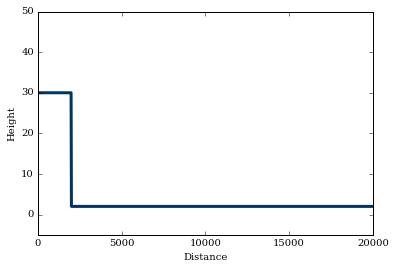

In [36]:
nx = 1001 #number of spatial steps
nt = 500 #number of time steps
L = 20000 #length of river bed
dx = L/(nx-1)
x = numpy.linspace(0,L,nx) #x grid

h = lahar_initial(nx, h_max, h_initial)

pyplot.plot(x, h, linewidth = 3, ls = '-', color='#003366')
pyplot.ylim(-5,50);
pyplot.xlabel('Distance')
pyplot.ylabel('Height')

In [25]:
u_max = 4.0 #maximum velocity of the lahar, m/s
sigma = 1.0 
dt = sigma * dx / u_max

In [34]:
h_n, vel = lahar_maccormack(h, nt, dt, dx, beta, k)

## Animating our results

In [27]:
from matplotlib import animation
from IPython.display import HTML

In [28]:
def animate(data):
    x = numpy.linspace(0, L, nx)
    y = data
    line.set_data(x,y)
    return line,

In [ ]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,L),ylim=(0,50),xlabel=('Distance'),ylabel=('Height'));
line, = ax.plot([],[],color='#003366',lw=3)

anim = animation.FuncAnimation(fig, animate, frames = h_n, interval = 50)
HTML(anim.to_html5_video())

## Calculations of velocity at bottom, size of deposit

In [35]:
#Velocity at the bottom calculation
vel=numpy.mean(vel)
print('Velocity of deposit at bottom (m/s): {0:f}'.format(vel))

Velocity of deposit at bottom (m/s): 0.856168


In [38]:
#Size of the deposit at the bottom
deposit = numpy.sum(h_n*dx)
print('Size of deposit at bottom (m^3): {0:f}'.format(deposit))

Size of deposit at bottom (m^3): 79552961.974933


## Conclusions

We have successfully modeled a lahar as a one dimensional, nonlinear advection equation. We used the MacCormack scheme to solve for the height of the lahar as a function of space and time. We were able to find the velocity and size of the lahar deposit and the bottom of our slope. 

## Dig Deeper ...

This model of a lahar did not account for bulking and debulking. However, there are numerical models that have investigated adding in these terms-- see [5]. How could we manipulate our governing equation to include bulking and debulking? Would we continue to use the MacCormack scheme?

## References

[1] Program, Volcano Hazards. "USGS: Volcano Hazards Program." USGS: Volcano Hazards Program. N.p. n.d. Web. 5 Dec. 2016.

[2] Pierson, Thomas C., Nathan J. Wood, and Carolyn L. Driedger. "Reducing risk from lahar hazards: concepts, case studies, and roles for scientists." Journal of Applied Volcanology 3.1 (2014): 1

[3] Slingerland, Rudy, and Lee R. Kump. Mathematical Modeling of Earth's Dynamical Systems: A Primer. Princeton, NJ: Princeton UP, 2011. Print

[4] Numerical MOOC- Module 3, Lesson 2

[5] Fagents, Sara A., and Stephen M. Baloga. "Toward a Model for the Bulking and Debulking of Lahars." Journal of Geophysical Research 111.B10 (2006): n. pag. Web. 

In [ ]:
from IPython.core.display import HTML
css_file = 'numericalmoocstyle.css'
HTML(open(css_file,"r").read())